# Notebook Setup

In [1]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    # MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/TFT_baseline"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    # MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"
    MY_HOME_ABS_PATH = "/home/ec2-user/SageMaker/co2-flux-hourly-gpp-modeling"

## Import Modules

In [2]:
import os
os.chdir(MY_HOME_ABS_PATH)

import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters, MetricsCallback
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import optuna
from optuna.integration import PyTorchLightningPruningCallback, TensorBoardCallback

# from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle


# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib_for_nbinstance import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

2023-04-15 06:48:48.838084: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 06:48:48.887470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 06:48:49.551365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 42
Global seed set to 42


42

In [3]:
# data/models/tft_model_1yrtrain_tuning_230318_1906/trial_0/epoch=12.ckpt

## Define Local File System Constants

In [4]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + '.tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + '.cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'
model_objects_dir = root_dir + os.sep + 'code/src/modeling/model_objects'

# Load Train and Test dataset from Azure Storage Blob

In [5]:
container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"

local_file = tmp_dir + os.sep + blob_name

In [6]:
# def get_raw_datasets(container, blob_name):
local_file = tmp_dir + os.sep + blob_name
data_df = None
if not (os.path.exists(local_file)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name)
    data_df = pd.read_parquet(file_stream, engine='pyarrow')
    data_df.to_parquet(local_file)
else:
    data_df = pd.read_parquet(local_file)

print(f"Data size: {data_df.shape}")

# Convert Dtypes
cat_cols = ["year", "month", "day", "hour", "MODIS_IGBP", "koppen_main", "koppen_sub", 
            "gap_flag_month", "gap_flag_hour"]
for col in cat_cols:
    data_df[col] = data_df[col].astype(str).astype("category")

print(f"Data Columns: {data_df.columns}")
print(f"NA count: {data_df.isna().sum().sum()}")
# return data_df

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Load Best GPP TFTAs of April 14

In [7]:
best_model_path_GPP = f"{MY_HOME_ABS_PATH}/data/models/GPPTFT_5yrTrain_2WkEncode_230410_2310/lightning_logs/version_1/checkpoints/epoch=9-step=74795.ckpt"

In [8]:
best_GPP = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
print(f"Quantiles: {best_GPP.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]


# Make prediction for three best models

In [9]:
exp_model_dir = "{MY_HOME_ABS_PATH}/data/models/GPPTFT_5yrTrain_2WkEncode_230410_2310" # TODO: Replace to your model dir
best_model_path = "./data/models/GPPTFT_5yrTrain_2WkEncode_230410_2310/lightning_logs/version_1/checkpoints/epoch=9-step=74795.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX  = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*5 # 5 year
ENCODER_LEN = 24*14
print(f"Training timestemp length = {SUBSET_LEN}.")

# Create dataloaders for model
batch_size = 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
Training timestemp length = 43800.


## Create TS Dataset

In [10]:
# Setup dataset
train_df, val_df, test_df = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, test_df = subset_data(train_df, val_df, test_df, SUBSET_LEN)

Subest length: 43800 timesteps for each sites
Subset num train timesteps: 2579424
Subset num val timesteps: 952752
Subset num test timesteps: 891744


# Decide sites in use

In [11]:
val_df.head()

,GPP_NT_VUT_REF,site_id,timestep_idx_local,timestep_idx_global,datetime,date,year,month,day,hour,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,lat,long,koppen_sub,koppen_main,c3c4,c4_percent,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,MODIS_LC,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,MODIS_IGBP,MODIS_PFT,gap_flag_hour,gap_flag_month
153528,-0.46940,AU-DaP,0,350640,2010-01-01 00:00:00,2010-01-01,2010,1,1,0,24.47000,0.00000,416.09000,2.21000,0.00000,99.83900,0.56131,0.74435,0.31742,0.05892,0.41990,0.02462,0.09036,0.41006,0.28214,0.12812,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153529,-0.44756,AU-DaP,1,350641,2010-01-01 01:00:00,2010-01-01,2010,1,1,1,23.79100,0.00000,409.45000,1.01800,0.00000,99.81200,0.51946,0.71901,0.28217,0.06444,0.39286,0.02698,0.08792,0.41804,0.30312,0.13154,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153530,-0.43325,AU-DaP,2,350642,2010-01-01 02:00:00,2010-01-01,2010,1,1,2,23.45600,0.00000,409.45000,0.80100,0.00000,99.76000,0.58092,0.74910,0.33465,0.06188,0.44276,0.02548,0.09302,0.41848,0.29022,0.12242,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153531,-0.40639,AU-DaP,3,350643,2010-01-01 03:00:00,2010-01-01,2010,1,1,3,23.12200,0.00000,409.45000,0.58400,0.00000,99.70800,0.64758,0.77458,0.38791,0.06068,0.49500,0.02542,0.09588,0.43856,0.29074,0.11474,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0
153532,-0.39665,AU-DaP,4,350644,2010-01-01 04:00:00,2010-01-01,2010,1,1,4,22.79400,0.00000,400.83300,0.40800,0.00000,99.69300,0.67512,0.79451,0.40270,0.05670,0.50416,0.02536,0.09438,0.45466,0.27622,0.10274,GRA,-14.06330,131.31810,3,1,C3,97.83000,116.00000,63.00000,231.00000,0.46453,-0.00719,301.48530,0.29788,10,0.08345,0.00000,0.59000,2.00000,309.50000,297.52000,GRA,GRA,0.0,0.0


In [12]:
site_list = val_df["site_id"].unique()

In [13]:
val_df[['site_id','MODIS_IGBP']].drop_duplicates().reset_index(drop=True)

,site_id,MODIS_IGBP
0,AU-DaP,GRA
1,AU-Emr,GRA
2,AU-Gin,SAV
3,AU-How,SAV
4,AU-Rig,GRA
5,CA-Ca1,ENF
6,CA-Gro,MF
7,CH-Fru,MF
8,CH-Oe2,CRO
9,DE-Hai,DBF


In [14]:
# AU-DaP	GrassLand GRA

# NL-Loo	SAV	SAV Savanna
# US-Ses	OSH Open Shrublands
# CA-Gro	MF Mixed Forest
# US-Bar	DBF 
# FI-Hyy	ENF Evergreen Needleleaf Forest
# FR_Aur	CRO Cropland

In [15]:
val_AU_DaP_df = val_df[val_df["site_id"] == "AU-DaP"]
# val_NL_Loo_df = val_df[val_df["site_id"] == "NL-Loo"]
# val_US_Ses_df = val_df[val_df["site_id"] == "US-Ses"]
# val_CA_Gro_df = val_df[val_df["site_id"] == "CA-Gro"]
# val_US_Bar_df = val_df[val_df["site_id"] == "US-Bar"]
# val_FI_Hyy_df = val_df[val_df["site_id"] == "FI-Hyy"]
# val_FR_Aur_df = val_df[val_df["site_id"] == "FR-Aur"]


print(val_AU_DaP_df.shape)
# print(val_NL_Loo_df.shape)
# print(val_US_Ses_df.shape)
# print(val_CA_Gro_df.shape)
# print(val_US_Bar_df.shape)
# print(val_FI_Hyy_df.shape)
# print(val_FR_Aur_df.shape)


(32304, 51)


# Convert to TS dataset

In [16]:
min_encoder_len = ENCODER_LEN

training = TimeSeriesDataSet(
      train_df,
      time_idx="timestep_idx_global",
      target="GPP_NT_VUT_REF",
      group_ids=["site_id"],
      allow_missing_timesteps=False, # <---- turned on bc some rows are removed.
      min_encoder_length=min_encoder_len,
      max_encoder_length=min_encoder_len,
      min_prediction_length=1,
      max_prediction_length=1,
      static_categoricals=["MODIS_IGBP","koppen_main","koppen_sub"],
      static_reals=[],
      time_varying_known_categoricals=["month", "day", "hour"],
      time_varying_known_reals=["timestep_idx_global", 
                                'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA',
                                'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 
                                'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 
                                'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day','LST_Night'],
      time_varying_unknown_categoricals=["gap_flag_month", "gap_flag_hour"], 
      time_varying_unknown_reals=["GPP_NT_VUT_REF"],
      target_normalizer=None,
      categorical_encoders={'MODIS_IGBP': NaNLabelEncoder(add_nan=True),
                            'koppen_main': NaNLabelEncoder(add_nan=True),
                            'koppen_sub': NaNLabelEncoder(add_nan=True),
                            'year': NaNLabelEncoder(add_nan=True),
                            },
      add_relative_time_idx=True,
      add_target_scales=False, # <------- turned off
      add_encoder_length=False, # <------- turned off
    )

In [22]:
# validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)

val_AU_DaP = TimeSeriesDataSet.from_dataset(training, val_AU_DaP_df, predict=False, stop_randomization=True)
# val_NL_Loo = TimeSeriesDataSet.from_dataset(training, val_NL_Loo_df, predict=False, stop_randomization=True)
# val_US_Ses = TimeSeriesDataSet.from_dataset(training, val_US_Ses_df, predict=False, stop_randomization=True)
# val_CA_Gro = TimeSeriesDataSet.from_dataset(training, val_CA_Gro_df, predict=False, stop_randomization=True)
# val_US_Bar = TimeSeriesDataSet.from_dataset(training, val_US_Bar_df, predict=False, stop_randomization=True)
# val_FI_Hyy = TimeSeriesDataSet.from_dataset(training, val_FI_Hyy_df, predict=False, stop_randomization=True)
# val_FR_Aur = TimeSeriesDataSet.from_dataset(training, val_FR_Aur_df, predict=False, stop_randomization=True)


# Create Data Loader

In [17]:
del train_df

In [18]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=cpu_count)#, pin_memory=True)
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)#, pin_memory=False)


### Define TS Dataset for NO-PAST-GPP models

In [148]:
# (training_NO_PAST_GPP, validation_NO_PAST_GPP, testing_NO_PAST_GPP) = setup_tsdataset_no_past_GPP(train_df, val_df, test_df, ENCODER_LEN)


In [149]:
# # Get small test data
# subtest_df = test_df.loc[test_df['timestep_idx_local'] < ENCODER_LEN+5, ].copy()
# _, _, subtesting = setup_tsdataset(train_df, val_df, subtest_df, ENCODER_LEN)
# print(f"Subset num subtest timesteps: {len(subtest_df)}")

# # create dataloaders for model
# # ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
# batch_size = 64  # set this between 32 to 128
# cpu_count = os.cpu_count()

In [156]:

# # Create TFT model from dataset
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.00001,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     attention_head_size=1, # Set to up to 4 for large datasets
#     dropout=0.3, # Between 0.1 and 0.3 are good values
#     hidden_continuous_size=16,  # set to <= hidden_size
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     logging_metrics=nn.ModuleList([MAE(), RMSE()]),
#     reduce_on_plateau_patience=2, # reduce learning rate if no improvement in validation loss after x epochs
#     optimizer="adam"
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=6, mode="min", check_finite=True, verbose=False,)
# lr_logger = LearningRateMonitor()  # log the learning rate
# checkpoint_callback = ModelCheckpoint(dirpath=exp_model_dir, save_top_k=3, monitor="val_loss") # save model objects for top k epoch val loss
# logger = TensorBoardLogger(exp_model_dir)  # logging results to a tensorboard

# trainer = pl.Trainer(
#     max_epochs=25,
#     enable_model_summary=True,
#     #gradient_clip_val=2,
#     fast_dev_run=False, 
#     accelerator='gpu',
#     devices="auto", 
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
#     strategy="ddp",
# )

## Prepare Two Validation Data Loaders

In [19]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [22]:
# Eval on Validation set
# def val_actuals(validation_ts):
#     val_dataloader = validation_ts.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)
#     # Comment out to save memorys
#     # val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
#     return val_dataloader#, val_actuals

In [28]:
val_loader_AU_DaP = val_actuals(val_AU_DaP) #, val_AU_DaP_actuals

In [20]:
def pred_raw(val_dataloader):
    print(f"Start eval on validation.")
    start = default_timer()
    val_raw_pred, val_x = best_GPP.predict(val_dataloader, show_progress_bar=True,
                                                   mode="raw", return_x=True)
    eval_time = default_timer() - start
    print(f"Val eval time: {eval_time}")
    return  val_raw_pred, val_x

In [21]:
def raw_pred_x_to_dict(model_name, val_or_test, site_name, val_raw_pred, val_x):
    
    
    # Store raw_predictions
    # Create dictionary
    val_raw_pred_dict = {}
    for i in val_raw_pred.keys():
        val_raw_pred_dict[i] = val_raw_pred[i]
    val_raw_pred_dict.keys()
    
    with open(f'{val_or_test}_raw_pred_{site_name}_{model_name}.pkl', 'wb') as handle:
        pickle.dump(val_raw_pred_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # open pickle from storage
    with open(f'{val_or_test}_raw_pred_{site_name}_{model_name}.pkl', 'rb') as handle:
        val_raw_pred_site = pickle.load(handle)
 
    # Store x
    val_x_dict = {}
    for i in val_x.keys():
        val_x_dict[i] = val_x[i]
    val_x_dict.keys()
    
    with open(f'{val_or_test}_x_pred_{site_name}_{model_name}.pkl', 'wb') as handle:
        pickle.dump(val_x_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # open pickle from storage
    with open(f'{val_or_test}_x_pred_{site_name}_{model_name}.pkl', 'rb') as handle:
        val_x_site = pickle.load(handle)
                                                       
    return val_raw_pred_site, val_x_site


# Sample Val Prediction AU-DaP

In [37]:
val_raw_AU_DaP, val_x_AU_DaP = pred_raw(val_loader_AU_DaP)

Start eval on validation.


Predict: 100%|██████████| 250/250 [04:43<00:00,  1.14s/ batches]

Val eval time: 283.82525439100027


In [38]:
model_name = "GPPTFT_5yrTrain_2WkEncode_230410_2310"
site_name = "AU_DaP"

raw_AU_DaP, x_AU_DaP = raw_pred_x_to_dict(model_name, site_name, val_raw_AU_DaP, val_x_AU_DaP)

In [46]:
val_raw_AU_DaP.keys()

('prediction',
 'encoder_attention',
 'decoder_attention',
 'static_variables',
 'encoder_variables',
 'decoder_variables',
 'decoder_lengths',
 'encoder_lengths')

In [47]:
val_raw_AU_DaP['encoder_variables'].shape

torch.Size([31968, 336, 1, 37])

In [43]:
# val_loader_AU_DaP = val_actuals(val_AU_DaP)
raw_AU_DaP.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [53]:
x_AU_DaP.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [49]:
del val_AU_DaP_df

In [52]:
del val_loader_AU_DaP

In [50]:
del val_raw_AU_DaP, val_x_AU_DaP 

# Predict on different val sites

Define the functions that do prediction end-to-end

In [22]:
def site_raw_pred(model_name, site_name, val_or_test, df, training):
    # filter with site id
    df_site = df[df["site_id"] == site_name]
    print(f'filtered with {site_name}')
    
    # create TS dataset
    df_site_ts = TimeSeriesDataSet.from_dataset(training,
                                                df_site,
                                                predict=False, stop_randomization=True)
    print(f'TS dataset created')
    # create dataloader
    site_dataloader = df_site_ts.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)
    print(f'dataloader created')
    
    # obtain raw prediction and x
    raw_pred, x = pred_raw(site_dataloader)
    print(f'prediction completed')
    
    # convert to dict and save to pkl
    print(f'saving to pickle')
    raw_pred_dict, x_dict = raw_pred_x_to_dict(model_name, val_or_test, site_name, raw_pred, x)
    
    print(f'deleting used files')
    del df_site, df_site_ts, site_dataloader, raw_pred, x

    return raw_pred_dict, x_dict
    

In [60]:
model_name = "GPPTFT_5yrTrain_2WkEncode_230410_2310"
site_name = "US-AR1"

raw_US_AR1, x_US_AR1 = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with US-AR1
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 203/203 [03:50<00:00,  1.13s/ batches]


Val eval time: 230.0536716810002
prediction completed
saving to pickle


In [ ]:
# AU-DaP	GrassLand GRA
# US-AR1	GrassLand GRA
# US-Bar	DBF 
# FI-Hyy	ENF Evergreen Needleleaf Forest
# FR_Aur	CRO Cropland

In [35]:
model_name = "GPPTFT_5yrTrain_2WkEncode_230410_2310"
site_name = "FI-Hyy"

raw_FI_Hyy, x_FI_Hyy = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with FI-Hyy
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 340/340 [06:22<00:00,  1.13s/ batches]


Val eval time: 382.6105321379998
prediction completed
saving to pickle
deleting used files


In [28]:
model_name = "GPPTFT_5yrTrain_2WkEncode_230410_2310"
site_name = "US-Bar"

raw_US_Bar, x_US_Bar = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with US-Bar
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 340/340 [06:38<00:00,  1.17s/ batches]


Val eval time: 398.09935127799986
prediction completed
saving to pickle
deleting used files


In [23]:
model_name = "GPPTFT_5yrTrain_2WkEncode_230410_2310"
site_name = "FR-Aur"

raw_FR_Aur, x_FR_Aur = site_raw_pred(model_name, site_name, "val", val_df, training)

filtered with FR-Aur
TS dataset created
dataloader created
Start eval on validation.


Predict: 100%|██████████| 340/340 [06:33<00:00,  1.16s/ batches]


Val eval time: 393.3296462819999
prediction completed
saving to pickle
deleting used files


## Try predction with data

In [25]:
test_df[['site_id','MODIS_IGBP']].drop_duplicates().reset_index(drop=True)

,site_id,MODIS_IGBP
0,AU-Stp,GRA
1,AU-Whr,GRA
2,CA-Oas,DBF
3,CH-Dav,WSA
4,CZ-Lnz,DBF
5,CZ-wet,WET
6,DE-Gri,ENF
7,DE-Lnf,CRO
8,DE-Tha,CRO
9,ES-Amo,OSH


# (Reference)Model Interpretation

In [ ]:
print(f'encoder variables: {best_GPP.encoder_variables}')
encoder_var = best_GPP.encoder_variables
len(best_GPP.encoder_variables)

### Interpret_output
- reduction: "none" for no averaging over batches, 
- "sum" for summing attentions, 
- "mean" for normalizing by encode lengths
- attention_prediction_horizon: which prediction horizon to use for attention

In [ ]:
interpretation_none = best_tft.interpret_output(val_raw_predictions, reduction="none")
interpretation_sum = best_tft.interpret_output(val_raw_predictions, reduction="sum")
interpretation_mean = best_tft.interpret_output(val_raw_predictions, reduction="mean")

In [ ]:
# size of val_raw_predictions['encoder_variables']
print(val_raw_predictions['encoder_variables'].shape)

When encoder length is 24 times 7, Each feature has 168 feature importance in each prediction time point

In [ ]:
print(val_raw_predictions['encoder_variables'][0].shape)
val_raw_predictions['encoder_variables'][0]


In [ ]:
print(val_raw_predictions['encoder_variables'][0][0].shape)
val_raw_predictions['encoder_variables'][0][0]

In [ ]:
print(len(val_raw_predictions['encoder_variables'][0][0][0]))
print(val_raw_predictions['encoder_variables'][0][0].sum())
val_raw_predictions['encoder_variables'][0][0]

### Interpretation reduction="none"

In [ ]:
print(interpretation_none['encoder_variables'].shape)
interpretation_none['encoder_variables']

In [ ]:
print(interpretation_none['encoder_variables'][0].sum())
interpretation_none['encoder_variables'][0]

### Interpretation reduction="sum"

In [ ]:
print(interpretation_sum['encoder_variables'].sum())
print(len(interpretation_sum['encoder_variables']))
interpretation_sum['encoder_variables']

### Interpretation reduction="mean"

In [ ]:
print(interpretation_mean['encoder_variables'].sum())
print(len(interpretation_mean['encoder_variables']))
interpretation_mean['encoder_variables']

### Compare with manual normalization

In [ ]:
# Sum manually 
interpret_none_df = pd.DataFrame(interpretation_none['encoder_variables'], columns=encoder_var)
interpret_none_df.sum()

### Normalize sum of importance

In [ ]:
interpret_none_df.mean()

In [ ]:
importance_rank = pd.DataFrame(interpret_none_df.mean(),columns=["importance"]).sort_values(by="importance", ascending=False)
importance_rank

In [ ]:
# 19 features cover 80% of total importance
importance_rank[:19].sum()

# Create df importance of the snapshot of one prediction time point

In [63]:
raw_pred = raw_FR_Aur
raw_FR_Aur.keys()

dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths'])

In [64]:
x = x_FR_Aur
x_FR_Aur.keys()

dict_keys(['encoder_cat', 'encoder_cont', 'encoder_target', 'encoder_lengths', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_lengths', 'decoder_time_idx', 'groups', 'target_scale'])

In [36]:
print(SUBSET_LEN)
TRAIN_LEN = SUBSET_LEN/365/24
ENCODER_LEN 

43800


336

In [29]:
datetime_list = [[2010,8,1,0],[2010,8,1,12],[2011,1,1,0],[2011,1,1,12]]

In [108]:
year = 2010
month = 8
day = 1
hour = 0

def snapshot_stack_TFT_fi(site_name, df, TRAIN_LEN, ENCODER_LEN, # df is val_df or test_df
                          raw_pred, x,
                          year, month, day, hour):
    
    print(f'Site_Name: {site_name}')
    print(f'Train Size: {int(TRAIN_LEN)}, Encoder Length {ENCODER_LEN}')
    print(f'Year/ Date/ Hour of the prediction time t: {year}-{month}-{day} {hour}(hour)')

    # Search the global index for the desireable datetime
    global_time_idx = df[df["site_id"] == site_name][df["year"]== str(year) ][df["month"]== str(month)][df["day"]== str(day)][df["hour"]== str(hour)]['timestep_idx_global'].reset_index(drop=True)[0]
    print(f'global_time_idx: {global_time_idx}')

    # Find which index in raw prediction and x
    for idx, time_idx in enumerate(val_x["decoder_time_idx"]):
        if time_idx == global_time_idx:
            raw_x_index = idx
            print(idx)
            break

    # tensor to list
    encoder_fi = []
    for i in raw_pred['encoder_variables'][raw_x_index]:
        encoder_fi += [list(i.numpy()[0])]

    # column name(feature name) and order
    tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path_GPP)
    encoder_var = tft.encoder_variables
    print(f'encoder_variables: {encoder_var}')

    # Define encoder index -1 to -168( or -336)
    encoder_fi_df = pd.DataFrame(encoder_fi, columns=encoder_var)
    encoder_index = [-(ENCODER_LEN -i) for i in range(ENCODER_LEN)]
    encoder_index#.reverse()

    # Add encoer index
    encoder_fi_df["encoder_index"] = encoder_index
    
    # encoder_index comes first column
    columns_order = list(encoder_fi_df.columns[-1:]) + list(encoder_fi_df.columns[:-1])
    encoder_size_fi_df  = encoder_fi_df[columns_order]
    
    # add encoder attention to df 
    encoder_size_fi_df["encoder_attention"] = list(raw_pred["encoder_attention"][idx][0][0].numpy())

    
    return encoder_size_fi_df

In [109]:
print(site_name)
df = val_df
print(TRAIN_LEN)
print(ENCODER_LEN)
raw_pred = raw_FR_Aur
x = x_FR_Aur

FR-Aur
5.0
336


In [112]:
encoder_fi_FR_Aur =  snapshot_stack_TFT_fi(site_name, df, TRAIN_LEN, ENCODER_LEN, # df is val_df or test_df
                      raw_pred, x,
                      year, month, day, hour)
encoder_fi_FR_Aur.head()

Site_Name: FR-Aur
Train Size: 5, Encoder Length 336
Year/ Date/ Hour of the prediction time t: 2010-8-1 0(hour)
global_time_idx: 355728
4752
encoder_variables: ['month', 'day', 'hour', 'gap_flag_month', 'gap_flag_hour', 'timestep_idx_global', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA', 'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily', 'PET', 'Ts', 'ESACCI-sm', 'NDWI', 'Percent_Snow', 'Fpar', 'Lai', 'LST_Day', 'LST_Night', 'relative_time_idx', 'GPP_NT_VUT_REF']


,encoder_index,month,day,hour,gap_flag_month,gap_flag_hour,timestep_idx_global,TA_ERA,SW_IN_ERA,LW_IN_ERA,VPD_ERA,P_ERA,PA_ERA,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7,BESS-PAR,BESS-PARdiff,BESS-RSDN,CSIF-SIFdaily,PET,Ts,ESACCI-sm,NDWI,Percent_Snow,Fpar,Lai,LST_Day,LST_Night,relative_time_idx,GPP_NT_VUT_REF,encoder_attention
0,-336,0.00738,0.00893,0.00456,0.00202,0.06562,0.01856,0.09426,0.01199,0.01023,0.01709,0.02637,0.01853,0.01286,0.02872,0.01324,0.02631,0.00341,0.00351,0.01898,0.01251,0.01282,0.00381,0.01810,0.01194,0.00958,0.00868,0.01544,0.01294,0.00266,0.01877,0.00274,0.03134,0.01828,0.01599,0.01315,0.34088,0.05777,0.01560
1,-335,0.00759,0.00912,0.00490,0.00205,0.07257,0.01856,0.09313,0.01248,0.01059,0.01775,0.02846,0.01977,0.01334,0.02895,0.01399,0.02740,0.00345,0.00354,0.01963,0.01302,0.01330,0.00389,0.01885,0.01242,0.00991,0.00877,0.01608,0.01279,0.00261,0.01977,0.00275,0.03300,0.01955,0.01662,0.01361,0.31450,0.06132,0.00489
2,-334,0.00758,0.00928,0.00509,0.00203,0.07275,0.01775,0.08976,0.01252,0.01060,0.01789,0.02919,0.01997,0.01338,0.02853,0.01418,0.02751,0.00339,0.00359,0.01969,0.01315,0.01335,0.00390,0.01892,0.01228,0.00991,0.00873,0.01617,0.01277,0.00261,0.02013,0.00270,0.03338,0.01996,0.01701,0.01360,0.31389,0.06287,0.00258
3,-333,0.00756,0.00968,0.00537,0.00216,0.08374,0.01961,0.09636,0.01326,0.01112,0.01845,0.03081,0.02147,0.01412,0.02812,0.01384,0.02817,0.00345,0.00370,0.02060,0.01385,0.01401,0.00417,0.02001,0.01343,0.01035,0.00876,0.01705,0.01200,0.00259,0.02090,0.00261,0.03446,0.02231,0.01757,0.01378,0.27255,0.06802,0.00138
4,-332,0.00760,0.00927,0.00506,0.00208,0.07588,0.01745,0.09056,0.01283,0.01081,0.01812,0.02949,0.02020,0.01364,0.02837,0.01370,0.02801,0.00348,0.00367,0.02007,0.01325,0.01358,0.00397,0.01922,0.01245,0.01006,0.00882,0.01643,0.01249,0.00255,0.02008,0.00268,0.03430,0.02051,0.01737,0.01333,0.30471,0.06392,0.00114


# Stack area + Attention plot

In [131]:
feature_list = []
topX = 7
encoder_fi_df =encoder_fi_FR_Aur
def stack_attention_plot(site_name, encoder_fi_df, feature_list, ENCODER_LEN, topX, datehour): 
    '''
    Function that creates plot with attention.
    Feature can be either assigned or selected from top features
    in "topX", provide integer between 5-10.
    If feature_list is blank, automatically choose topX(choose from 5-10)
    datehour need to be provided with format [year, month, day, hour] and each components should be string
    '''
    
    import seaborn as sns
    #set seaborn style
    sns.set_theme()
    pal = sns.color_palette("crest")
    sns.set(rc={'figure.figsize':(30,7), })

    if feature_list == []:
        encoder_fi_rank_df = pd.DataFrame(encoder_fi_df.sum()/ENCODER_LEN, columns=['avg_encoder_imp'])
        encoder_fi_rank_df = encoder_fi_rank_df.sort_values(by=['avg_encoder_imp'], ascending=False)
        topX_features = list(encoder_fi_rank_df[:topX].index)
        print(f'{topX} features')
        print(topX_features)
        feature_list = topX_features

    #create area chart
    if topX == 5:    
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],
                      labels=feature_list,
                      colors=pal)
    if topX == 6:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      labels=feature_list,
                      colors=pal)
    if topX == 7:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],
                      labels=feature_list,
                      colors=pal)
    if topX == 8:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      labels=feature_list,
                      colors=pal)

    if topX == 9:
        plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],
                      labels=feature_list,
                      colors=pal)

    if topX == 10:
         plt.stackplot(encoder_fi_df['encoder_index'], # x axis
                      encoder_fi_df[feature_list[0]],encoder_fi_df[feature_list[1]],
                      encoder_fi_df[feature_list[2]],encoder_fi_df[feature_list[3]],
                      encoder_fi_df[feature_list[4]],encoder_fi_df[feature_list[5]],
                      encoder_fi_df[feature_list[6]],encoder_fi_df[feature_list[7]],
                      encoder_fi_df[feature_list[8]],encoder_fi_df[feature_list[9]],
                      labels=feature_list,
                      colors=pal)

    # Reverse the order of labels in legend
    plt.legend(reversed(plt.legend().legendHandles), reversed(feature_list), loc='upper left', fontsize=14)

    #add axis labels
    plt.title(f'{site_name} Feature Importance by Encoder Length / Average Attention', fontsize=20)
    plt.ylabel('Importance (All Features Total 1.0)', fontsize=18)
    plt.xlabel(f'Encoder Relative Index (1hour before pred ~ {ENCODER_LEN}(24*{int(ENCODER_LEN/24)}) hours before pred)', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14) # fontsize of both axes

    plt2 = plt.twinx()

    plt2.plot(encoder_fi_df["encoder_index"], encoder_fi_df["encoder_attention"], color='pink', linewidth=5)
    plt2.set_ylabel('Average Attention', fontsize=18)
    plt2.tick_params('y', colors='k')
    plt.show()
    plt.savefig(f'fi_attention_GPP_TFT_{ENCODER_LEN}_{site_name}_{datehour[0]}-{datehour[1]}-{datehour[2]}-{datehour[3]}.png')

10 features
['relative_time_idx', 'gap_flag_hour', 'TA_ERA', 'GPP_NT_VUT_REF', 'b4', 'P_ERA', 'Fpar', 'Lai', 'timestep_idx_global', 'b1']


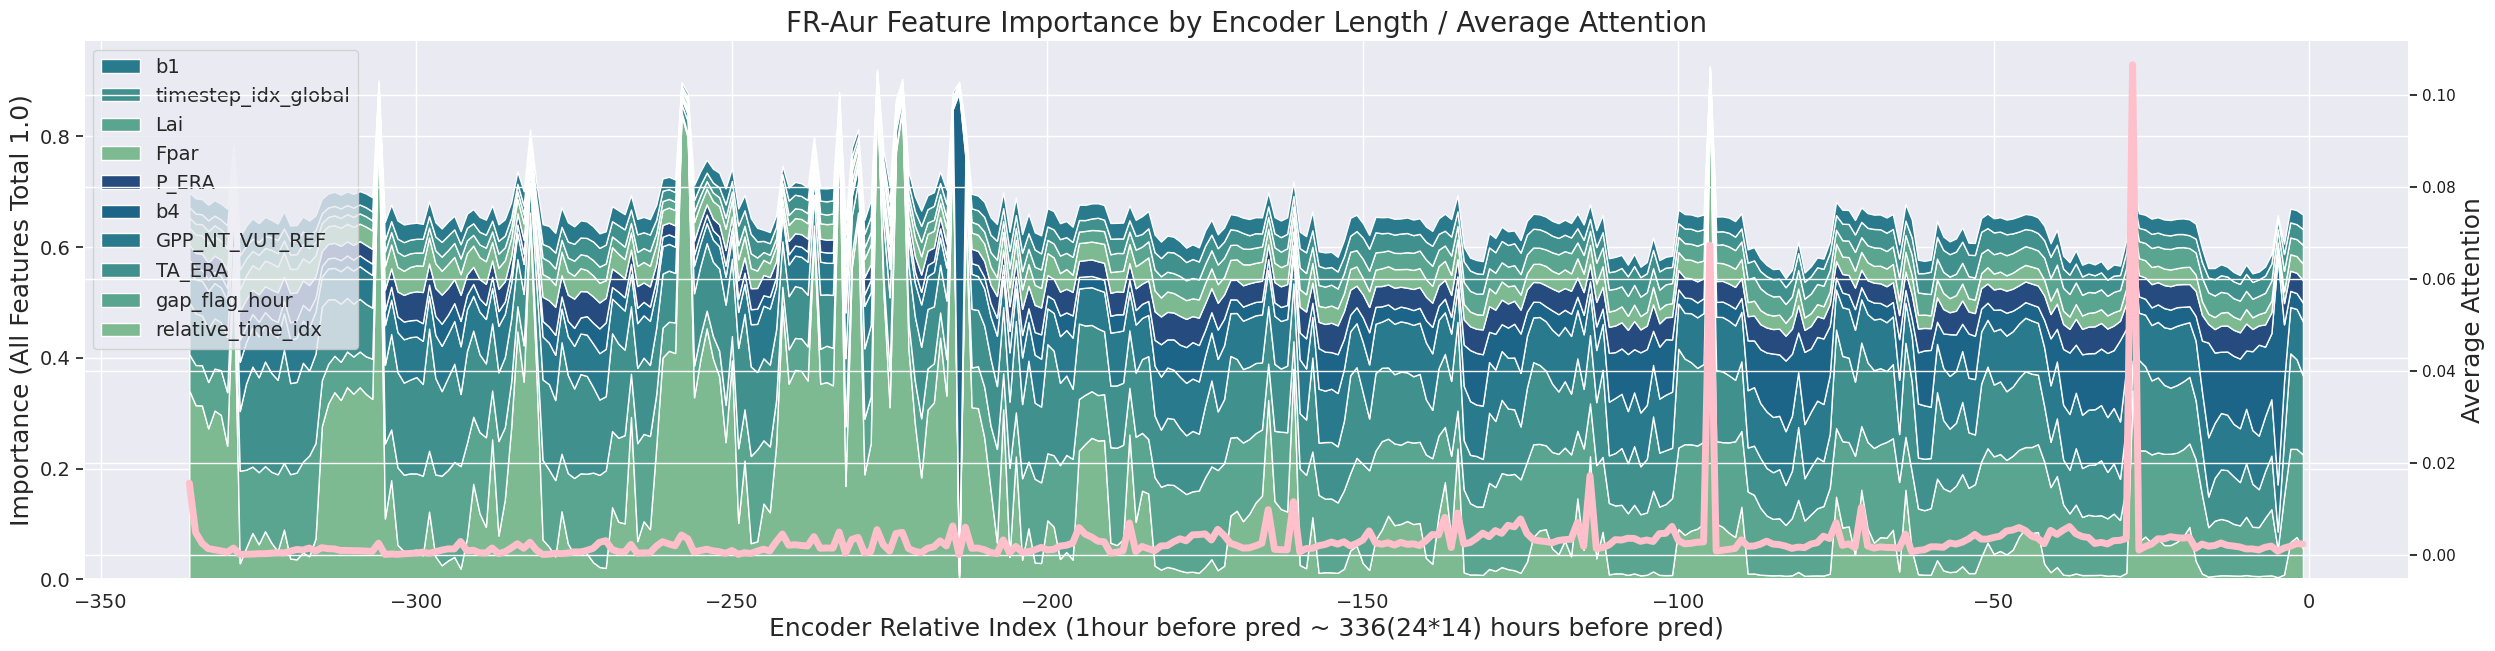

<Figure size 3000x700 with 0 Axes>

In [132]:
stack_attention_plot(site_name, encoder_fi_df, feature_list, ENCODER_LEN, 10, [str(year),str(month),str(day),str(hour)])